# Data2001 Assignment

In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

In [2]:
from __future__ import (absolute_import, division, print_function)

import pandas as pd
import psycopg2
import psycopg2.extras
import os
import json
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pandas.io.json import json_normalize
from sqlalchemy import create_engine
from shapely.geometry import Point, Polygon, MultiPolygon
from geopandas.tools import sjoin
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from shapely.wkt import loads

%matplotlib inline
import matplotlib.pyplot as plt

Please add your private details into the file Credentials.json to connect to the database

In [3]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [4]:
db, conn = pgconnect(credentials)

Connected successfully.


In [5]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


# Task 1: Import data

### 1. Create the Stops table

To create the Stops table, we first clean uneccesary data by dropping the columns. To obtain the 'geom' column, we have combined the longtitude and the latitude column into one. 

In [6]:
stops = pd.read_csv('Data/Stops.csv') #Orignal
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)  # creating the geometry column
stops = stops.drop(columns=['stop_lat', 'stop_lon'])  # removing the old latitude/longitude fields
srid = 4326 #SRID transformation
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops = stops.drop(columns=['stop_code', 'location_type', 'platform_code'])
conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(20), 
    stop_name VARCHAR(100), 
    parent_station VARCHAR(20),
    wheelchair_boarding INTEGER,
    geom GEOMETRY(POINT,4326)
);"""
)
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from stops")

,stop_id,stop_name,parent_station,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",200060,0,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,200054,"Central Station, Eddy Av, Stand D",200060,0,0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...
2,200060,Central Station,None,0,0101000020E6100000817FA2F299E662408FF33DAC29F1...
3,201510,Redfern Station,None,0,0101000020E61000009E57611C5DE6624060304CE622F2...
4,201646,"Redfern Station, Gibbons St, Stand B",201510,0,0101000020E6100000DBF9333D5DE662403DFA6B9D58F2...
...,...,...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",21271,1,0101000020E6100000AF9B3D8185E262408F52D7D537E9...
114714,2137185,"Cabarita Wharf, Side A",21371,1,0101000020E6100000EB409ADCBDE3624089CE4C0B9BEB...
114715,2137186,"Cabarita Wharf, Side B",21371,1,0101000020E6100000C4F9BEA2BDE362403EB375529EEB...
114716,21501,Parramatta Wharf,2150112,1,0101000020E6100000E443E4A456E0624025C1A4032EE8...


### 2. Create the Businesses table

In [7]:
businesses = pd.read_csv('Data/Businesses.csv')
businesses = businesses.rename(columns={"0_to_50k_businesses": "businesses_0_to_50k",
                           "50k_to_200k_businesses": "businesses_50k_to_200k",
                           "200k_to_2m_businesses": "businesses_200k_to_2m",
                           "2m_to_5m_businesses": "businesses_2m_to_5m",
                           "5m_to_10m_businesses": "businesses_5m_to_10m",
                           "10m_or_more_businesses": "businesses_10m_to_more"})
conn.execute("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    industry_code VARCHAR(10), 
    industry_name VARCHAR(100), 
    sa2_code VARCHAR(20),
    sa2_name VARCHAR(100),
    businesses_0_to_50k INTEGER,
    businesses_50k_to_200k INTEGER,
    businesses_200k_to_2m INTEGER,
    businesses_2m_to_5m INTEGER,
    businesses_5m_to_10m INTEGER,
    businesses_10m_to_more INTEGER,
    total_businesses INTEGER
);"""
)
businesses.to_sql('businesses', conn, if_exists='append', index=False)
query(conn, "select * from businesses")

,industry_code,industry_name,sa2_code,sa2_name,businesses_0_to_50k,businesses_50k_to_200k,businesses_200k_to_2m,businesses_2m_to_5m,businesses_5m_to_10m,businesses_10m_to_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


### 3. Create the Income table

In [8]:
income = pd.read_csv('Data/Income.csv')
np_rows = income[(income['earners'] == 'np') & 
                 (income['median_age'] == 'np') &
                 (income['median_income'] == 'np') &
                 (income['mean_income'] == 'np')]
income = income.drop(index=np_rows.index)
conn.execute("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code VARCHAR(20),
    sa2_name VARCHAR(100),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);"""
)
income.to_sql('income', conn, if_exists='append', index=False)
query(conn, "select * from income")

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2426,50,44246,61745
1,101021008,Karabar,5128,42,62946,67345
2,101021009,Queanbeyan,6778,39,61724,67276
3,101021010,Queanbeyan - East,3360,40,64010,71770
4,101021011,Queanbeyan Region,13502,44,74042,85303
...,...,...,...,...,...,...
565,128021537,Royal National Park,13,36,38956,61645
566,128021538,Sutherland - Kirrawee,13698,41,62453,71105
567,128021607,Engadine,10335,43,60914,70158
568,128021608,Loftus - Yarrawarrah,4498,45,60469,73218


### 4. Create the Population table

In [9]:
population = pd.read_csv('Data/Population.csv')
population = population.rename(columns={"0-4_people": "people_0to4",
                                        "5-9_people": "people_5to9",
                                        "10-14_people": "people_10to14",
                                        "15-19_people": "people_15to19",
                                        "20-24_people": "people_20to24",
                                        "25-29_people": "people_25to29",
                                        "30-34_people": "people_30to34",
                                        "35-39_people": "people_35to39",
                                        "40-44_people": "people_40to44",
                                        "45-49_people": "people_45to49",
                                        "50-54_people": "people_50to54",
                                        "55-59_people": "people_55to59",
                                        "60-64_people": "people_60to64",
                                        "65-69_people": "people_65to69",
                                        "70-74_people": "people_70to74",
                                        "75-79_people": "people_75to79",
                                        "80-84_people": "people_80to84",
                                        "85-and-over_people": "people_85_and_over",
                                       })
conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code VARCHAR(20),
    sa2_name VARCHAR(100),
    people_0to4 INTEGER,
    people_5to9 INTEGER,
    people_10to14 INTEGER,
    people_15to19 INTEGER,
    people_20to24 INTEGER,
    people_25to29 INTEGER,
    people_30to34 INTEGER,
    people_35to39 INTEGER,
    people_40to44 INTEGER,
    people_45to49 INTEGER,
    people_50to54 INTEGER,
    people_55to59 INTEGER,
    people_60to64 INTEGER,
    people_65to69 INTEGER,
    people_70to74 INTEGER,
    people_75to79 INTEGER,
    people_80to84 INTEGER,
    people_85_and_over INTEGER,
    total_people INTEGER
);"""
)
population.to_sql('population', conn, if_exists='append', index=False)
query(conn, "select * from population")

,sa2_code,sa2_name,people_0to4,people_5to9,people_10to14,people_15to19,people_20to24,people_25to29,people_30to34,people_35to39,...,people_45to49,people_50to54,people_55to59,people_60to64,people_65to69,people_70to74,people_75to79,people_80to84,people_85_and_over,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


### 5. Create the Polling table

In [10]:
polling = pd.read_csv('Data/PollingPlaces2019.csv')
polling = polling.drop(columns=['FID'])
polling['the_geom'] = gpd.points_from_xy(polling.longitude, polling.latitude)  # creating the geometry column
polling = polling.drop(columns=['longitude', 'latitude'])  # removing the old latitude/longitude fields
srid = 4326 #SRID transformation
polling['the_geom'] = polling['the_geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
conn.execute("""
DROP TABLE IF EXISTS polling;
CREATE TABLE polling (
    state VARCHAR(3),
    division_id VARCHAR(3),
    division_name VARCHAR(50),
    polling_place_id VARCHAR(10),
    polling_place_type_id INTEGER, 
    polling_place_name VARCHAR(100), 
    premises_name VARCHAR(100), 
    premises_address_1 VARCHAR(100), 
    premises_address_2 VARCHAR(100), 
    premises_address_3 VARCHAR(100), 
    premises_suburb VARCHAR(50),
    premises_state_abbreviation CHAR(3), 
    premises_post_code VARCHAR(10),
    the_geom GEOMETRY (POINT,4326)
);"""
)
polling.to_sql('polling', conn, if_exists='append', index=False, dtype={'the_geom': Geometry('POINT', srid)})
query(conn, "select * from polling")

,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,the_geom
0,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NSW,None,0101000020E6100000000000000000F87F000000000000...
1,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NSW,None,0101000020E6100000000000000000F87F000000000000...
2,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,None,None,None,None,NSW,None,0101000020E6100000000000000000F87F000000000000...
3,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,None,None,None,ORANGE,NSW,2800.0,0101000020E6100000000000000000F87F000000000000...
4,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,None,None,None,None,NSW,None,0101000020E6100000000000000000F87F000000000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,None,None,BARRACK HEIGHTS,NSW,2528.0,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2926,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,None,None,None,WARILLA,NSW,2528.0,0101000020E6100000BD32141C83DB624011F28B5C8146...
2927,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,None,None,WELBY,NSW,2575.0,0101000020E610000021B0726891CD6240386744696F38...
2928,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,None,None,WINDANG,NSW,2528.0,0101000020E6100000C1CAA145B6DB6240DC4603780B44...


### 6. Create the Catchment table

#### 6.1 Primary School Catchment table

In [11]:
primary_catchment = gpd.read_file("Data/catchments/catchments_primary.shp")
primary_catchment['ADD_DATE'] = pd.to_datetime(primary_catchment['ADD_DATE']).dt.strftime('%Y-%m-%d')
primary_catchment.columns = primary_catchment.columns.str.lower()
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

primaryog = primary_catchment.copy()  # creating a copy of the original for later
primary_catchment['geom'] = primary_catchment['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
primary_catchment = primary_catchment.drop(columns="geometry")  # deleting the old copy
conn.execute("""
DROP TABLE IF EXISTS primary_catchment;
CREATE TABLE primary_catchment (
    use_id CHAR(4),
    catch_type VARCHAR(20),
    use_desc VARCHAR(50),
    add_date DATE,
    kindergart CHAR(1),
    year1 CHAR(1),
    year2 CHAR(1),
    year3 CHAR(1),
    year4 CHAR(1),
    year5 CHAR(1),
    year6 CHAR(1),
    year7 CHAR(1),
    year8 CHAR(1),
    year9 CHAR(1),
    year10 CHAR(1),
    year11 CHAR(1),
    year12 CHAR(1),
    priority CHAR(1),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)
primary_catchment.to_sql("primary_catchment", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from primary_catchment")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,2018-12-10,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,2021-12-19,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,2022-02-23,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000065...
3,7308,PRIMARY,Plattsburg PS,2020-07-23,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E6100000010000000103000000010000003D...
4,4615,PRIMARY,Caddies Ck PS,2018-12-10,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E61000000100000001030000000100000056...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,2020-06-16,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,2020-03-15,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,2020-05-07,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,2020-05-07,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020E610000001000000010300000001000000F6...


#### 6.2 Secondary School Catchment table

In [12]:
secondary_catchment = gpd.read_file("Data/catchments/catchments_secondary.shp")
secondary_catchment['ADD_DATE'] = pd.to_datetime(secondary_catchment['ADD_DATE']).dt.strftime('%Y-%m-%d')
secondary_catchment.columns = secondary_catchment.columns.str.lower()
secondaryog = secondary_catchment.copy()  # creating a copy of the original for later
secondary_catchment['geom'] = secondary_catchment['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
secondary_catchment = secondary_catchment.drop(columns="geometry")  # deleting the old copy
conn.execute("""
DROP TABLE IF EXISTS secondary_catchment;
CREATE TABLE secondary_catchment (
    use_id CHAR(4),
    catch_type VARCHAR(20),
    use_desc VARCHAR(50),
    add_date DATE,
    kindergart CHAR(1),
    year1 CHAR(1),
    year2 CHAR(1),
    year3 CHAR(1),
    year4 CHAR(1),
    year5 CHAR(1),
    year6 CHAR(1),
    year7 CHAR(1),
    year8 CHAR(1),
    year9 CHAR(1),
    year10 CHAR(1),
    year11 CHAR(1),
    year12 CHAR(1),
    priority CHAR(1),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)
secondary_catchment.to_sql("secondary_catchment", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from secondary_catchment")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,8503,HIGH_COED,Billabong HS,2020-05-07,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,2020-05-07,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E61000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,2020-10-16,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,2021-11-15,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,2020-05-07,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,2021-12-21,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E61000000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,2023-04-05,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E610000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,2020-05-12,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,2020-05-12,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,0106000020E6100000010000000103000000010000005B...


#### 6.3 Future School Catchment table

In [13]:
future_catchment = gpd.read_file("Data/catchments/catchments_future.shp")
future_catchment['ADD_DATE'] = pd.to_datetime(future_catchment['ADD_DATE']).dt.strftime('%Y-%m-%d')
future_catchment.columns = future_catchment.columns.str.lower()
futureog = future_catchment.copy()  # creating a copy of the original for later
future_catchment['geom'] = future_catchment['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
future_catchment = future_catchment.drop(columns="geometry")  # deleting the old copy
conn.execute("""
DROP TABLE IF EXISTS future_catchment;
CREATE TABLE future_catchment (
    use_id CHAR(4),
    catch_type VARCHAR(20),
    use_desc VARCHAR(50),
    add_date DATE,
    kindergart INTEGER,
    year1 INTEGER,
    year2 INTEGER,
    year3 INTEGER,
    year4 INTEGER,
    year5 INTEGER,
    year6 INTEGER,
    year7 INTEGER,
    year8 INTEGER,
    year9 INTEGER,
    year10 INTEGER,
    year11 INTEGER,
    year12 INTEGER,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)
future_catchment.to_sql("future_catchment", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from future_catchment")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geom
0,8416,HIGH_COED,Ku-ring-gai HS,2023-01-14,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,2020-02-20,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E6100000010000000103000000010000006F...
2,8539,HIGH_COED,SSC Blackwattle Bay,2022-06-09,0,0,0,0,0,0,0,0,0,0,0,2024,2024,0106000020E610000001000000010300000001000000E3...
3,8286,HIGH_COED,Mt Annan HS,2022-03-01,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000099...
4,8400,HIGH_COED,St Ives HS,2023-01-14,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000060...
5,8555,HIGH_COED,Rose Bay SC,2020-02-20,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E6100000010000000103000000010000000C...
6,8556,CENTRAL_HIGH,Alexandria Park CS,2020-02-20,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E61000000100000001030000000100000028...
7,8584,HIGH_COED,Elizabeth Macarthur HS,2022-03-01,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E610000001000000010300000001000000BB...
8,8913,HIGH_COED,Inner Sydney HS,2020-02-20,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2025,0106000020E61000000100000001030000000100000076...
9,8135,HIGH_COED,Parramatta HS,2023-01-12,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,0106000020E6100000010000000103000000010000001F...


### 7. Create SA2 Region table

In [14]:
sa2 = gpd.read_file("Data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
not_greatersydney_row = sa2[sa2['GCC_NAME21'] != 'Greater Sydney']
sa2 = sa2.drop(index=not_greatersydney_row.index)
sa2 = sa2.drop(columns=['CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'STE_CODE21', 'AUS_CODE21', 'LOCI_URI21'])
sa2.columns = sa2.columns.str.lower()
sa2og = sa2.copy()  # creating a copy of the original for later
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2 = sa2.drop(columns="geometry")  # deleting the old copy
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    sa2_code21 VARCHAR(20),
    sa2_name21 VARCHAR(100),
    gcc_name21 VARCHAR (50),
    ste_name21 VARCHAR (50),
    aus_name21 VARCHAR (50),
    areasqkm21 NUMERIC,
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
)
sa2.to_sql("sa2", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2")

,sa2_code21,sa2_name21,gcc_name21,ste_name21,aus_name21,areasqkm21,geom
0,102011028,Avoca Beach - Copacabana,Greater Sydney,New South Wales,Australia,6.4376,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,Greater Sydney,New South Wales,Australia,32.0802,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,Greater Sydney,New South Wales,Australia,767.9512,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,Greater Sydney,New South Wales,Australia,33.7934,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,Greater Sydney,New South Wales,Australia,16.9123,0106000020E6100000010000000103000000010000007E...
...,...,...,...,...,...,...,...
368,128011530,Miranda - Yowie Bay,Greater Sydney,New South Wales,Australia,5.9968,0106000020E61000000100000001030000000100000046...
369,128011531,Sylvania - Taren Point,Greater Sydney,New South Wales,Australia,6.0595,0106000020E610000001000000010300000001000000F2...
370,128011602,Caringbah,Greater Sydney,New South Wales,Australia,3.9959,0106000020E610000001000000010300000001000000EF...
371,128021608,Loftus - Yarrawarrah,Greater Sydney,New South Wales,Australia,3.8436,0106000020E610000001000000010300000001000000A1...


In [15]:
conn.execute("CREATE INDEX IF NOT EXISTS sa2_spatial_index ON sa2 USING GIST(geom)")

# Task 2: Calculating score

### 1. Calculating z-score for retail per 1000 people

In [16]:
sql = """
SELECT sa2_name21, geom, (businesses_per_1000_people - AVG(businesses_per_1000_people) over()) / STDDEV_POP(businesses_per_1000_people) Over() AS z_score
FROM (
    SELECT sa2.sa2_name21,
           sa2.geom,
           b.total_businesses,
           p.total_people,
           (b.total_businesses * 1000.0)/ (CAST(p.total_people AS decimal))  AS businesses_per_1000_people
    FROM sa2
    LEFT JOIN businesses b ON (sa2.sa2_code21 = b.sa2_code)
    JOIN population p USING (sa2_code)
    WHERE p.total_people > 100 AND b.industry_name = 'Retail Trade'
    GROUP BY sa2.sa2_name21, b.total_businesses, p.total_people, sa2.geom
) subquery_alias
ORDER BY sa2_name21
"""
zretail = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-0.234085
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,0.150135
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-0.000833
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-0.332335
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.467989
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.400017
356,Wyong,0106000020E6100000010000000103000000010000002C...,-0.341845
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.134512
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-0.220819


### 2. Calculating z-score for health services per 1000 people

In [17]:
sql = """
SELECT sa2_name21, geom, (businesses_per_1000_people - AVG(businesses_per_1000_people) over()) / STDDEV_POP(businesses_per_1000_people) Over() AS z_score
FROM (
    SELECT sa2.sa2_name21,
           sa2.geom,
           b.total_businesses,
           p.total_people,
           (b.total_businesses * 1000.0)/(CAST(p.total_people AS decimal))  AS businesses_per_1000_people
    FROM sa2
    LEFT JOIN businesses b ON (sa2.sa2_code21 = b.sa2_code)
    JOIN population p USING (sa2_code)
    WHERE p.total_people > 100 AND b.industry_name = 'Health Care and Social Assistance'
    GROUP BY sa2.sa2_name21, b.total_businesses, p.total_people, sa2.geom
) subquery_alias
ORDER BY sa2_name21
"""
zhealth = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-0.258632
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,0.698696
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-0.535537
3,Artarmon,0106000020E610000001000000010300000001000000C3...,0.174957
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.619453
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.317355
356,Wyong,0106000020E6100000010000000103000000010000002C...,-0.538614
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.307358
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-0.781926


### 3. Calculating z-score for public transport stops per-sqkm

In [18]:
sql = """
SELECT sa2_name21, geom, (stops_per_sqkm - AVG(stops_per_sqkm) over()) / STDDEV_POP(stops_per_sqkm) Over() AS z_score
FROM (
    SELECT sa2.sa2_name21,
           sa2.areasqkm21,
           sa2.geom,
           COUNT(stops.stop_id) AS number_of_stops,
           COUNT(stops.stop_id)/sa2.areasqkm21 AS stops_per_sqkm
    FROM sa2
    LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
    JOIN population p ON (sa2.sa2_code21 = p.sa2_code)
    WHERE p.total_people > 100
    GROUP BY sa2.sa2_name21, sa2.areasqkm21, sa2.geom
) subquery_alias
ORDER BY sa2_name21
"""
zstops = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,1.027419
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,0.042364
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-0.450242
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-0.354119
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,0.925780
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.500870
356,Wyong,0106000020E6100000010000000103000000010000002C...,-0.931709
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,0.927745
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-1.714886


### 4. Calculating z-score for polling places per-sqkm

In [19]:
sql = """
SELECT sa2_name21, geom, (polling_per_sqkm - AVG(polling_per_sqkm) over()) / STDDEV_POP(polling_per_sqkm) Over() AS z_score
FROM (
    SELECT sa2.sa2_name21,
           sa2.areasqkm21,
           sa2.geom,
           COUNT(polling.polling_place_id) AS number_of_polling_location,
           COUNT(polling.polling_place_id)/sa2.areasqkm21 AS polling_per_sqkm
    FROM sa2
    LEFT JOIN polling ON ST_Contains(sa2.geom, polling.the_geom)
    JOIN population p ON (sa2.sa2_code21 = p.sa2_code)
    WHERE p.total_people > 100
    GROUP BY sa2.sa2_name21, sa2.areasqkm21, sa2.geom
) subquery_alias
ORDER BY sa2_name21
"""
zpolls = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,0.035316
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,0.891451
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,0.089321
3,Artarmon,0106000020E610000001000000010300000001000000C3...,0.113872
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.134883
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.206074
356,Wyong,0106000020E6100000010000000103000000010000002C...,-0.309741
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.235991
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-0.499920


### 5. Calculating z-score for school catchments areas per 1000 young people

In [20]:
sql = """
SELECT sa2_name21, geom, (school_per_young_people - AVG(school_per_young_people) over()) / STDDEV_POP(school_per_young_people) Over() AS z_score
FROM (
SELECT sa2.sa2_name21,
       sa2.geom,
       p.people_0to4 + p.people_5to9 + p.people_10to14 + p.people_15to19 AS young_people,
       COUNT(primary_catchment.use_id) AS primary_school,
       COUNT(secondary_catchment.use_id) AS secondary_school,
       COUNT(future_catchment.use_id) AS future_school,
       COUNT(primary_catchment.use_id) + COUNT(secondary_catchment.use_id) + COUNT(future_catchment.use_id) AS total_schools,
       ((COUNT(primary_catchment.use_id) + COUNT(secondary_catchment.use_id) + COUNT(future_catchment.use_id)) * 1000.0) /
       (CAST(p.people_0to4 + p.people_5to9 + p.people_10to14 + p.people_15to19 AS decimal)) AS school_per_young_people
FROM sa2
LEFT JOIN primary_catchment ON ST_Intersects(sa2.geom, primary_catchment.geom)
LEFT JOIN secondary_catchment ON ST_Intersects(sa2.geom, secondary_catchment.geom)
LEFT JOIN future_catchment ON ST_Intersects(sa2.geom, future_catchment.geom)
JOIN population p ON (sa2.sa2_code21 = p.sa2_code)
WHERE p.total_people > 100
GROUP BY sa2.sa2_name21, young_people, sa2.geom
) subquery_alias
ORDER BY sa2_name21
"""
zschools = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-0.480842
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,-0.345047
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-0.176389
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-0.397349
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.287477
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.321981
356,Wyong,0106000020E6100000010000000103000000010000002C...,-0.497256
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.377329
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,0.986869


### Calculating the score using sigmoid function

In [21]:
def sigmoid(x):
 return 1/(1 + np.exp(-x))

In [22]:
# Concatenate the dataframes
dfs = [zretail, zhealth, zstops, zpolls, zschools]
df = pd.concat(dfs)

# Group by sa2_name21 and calculate the sum of z_score for each group
given_group = df.groupby(['sa2_name21', 'geom'])['z_score'].sum().reset_index()
given_group['sigmoid'] = sigmoid(given_group['z_score'])

given_group

,sa2_name21,geom,z_score,sigmoid
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,0.089176,0.522279
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,1.437598,0.808082
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-1.073681,0.254704
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-0.794973,0.311102
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.584022,0.358008
...,...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-1.746297,0.148515
356,Wyong,0106000020E6100000010000000103000000010000002C...,-2.619165,0.067915
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.127446,0.468182
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-2.230682,0.097029


In [23]:
conn.execute("""
DROP TABLE IF EXISTS given_group;
CREATE TABLE given_group (
    sa2_name21 VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326),
    z_score NUMERIC,
    sigmoid NUMERIC
);"""
)
given_group.to_sql("given_group", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
given_group

,sa2_name21,geom,z_score,sigmoid
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,0.089176,0.522279
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,1.437598,0.808082
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-1.073681,0.254704
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-0.794973,0.311102
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.584022,0.358008
...,...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-1.746297,0.148515
356,Wyong,0106000020E6100000010000000103000000010000002C...,-2.619165,0.067915
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.127446,0.468182
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-2.230682,0.097029


# Task 3: Additional dataset

### 1. Dataset 1 - Spatial Data (JSON)

In [24]:
fire = gpd.read_file("Data/Emergency/Fire and Rescue NSW_EPSG4326.json")
fire = fire.drop(columns=['topoid', 'generalnameoid', 'objectmoddate', 'featuremoddate', 'alternativelabel', 'changetype', 'processstate', 'classsubtype', 'operationalstatus', 'featurereliabilitydate', 'attributereliabilitydate', 'capturesourcecode', 'capturemethodcode', 'planimetricaccuracy', 'verticalaccuracy', 'buildingcomplextype', 'relevance', 'startdate', 'enddate', 'lastupdate', 'shapeuuid', 'createdate', 'msoid', 'centroidid'])  # removing the old latitude/longitude fields
fire['lon'] = fire['geometry'].apply(lambda geom: geom.x)
fire['lat'] = fire['geometry'].apply(lambda geom: geom.y)
fire['geom'] = gpd.points_from_xy(fire.lon, fire.lat)  # creating the geometry column
fire = fire.drop(columns=['lon', 'lat', 'geometry'])
fire['geom'] = fire['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
fire

,generalname,urbanity,geom
0,LAURIETON FIRE STATION,U,POINT (152.796113687647 -31.64578348047414)
1,CROWS NEST FIRE STATION,U,POINT (151.19997837536852 -33.82816943526855)
2,MOSMAN FIRE STATION,U,POINT (151.2427994228422 -33.82522566448811)
3,PYRMONT FIRE STATION,U,POINT (151.19595993981142 -33.87143712297232)
4,EASTWOOD FIRE STATION,U,POINT (151.07739240230347 -33.79225731257263)
...,...,...,...
337,TUMBARUMBA FIRE STATION,U,POINT (148.01124386921455 -35.7799827375121)
338,THREDBO FIRE STATION,U,POINT (148.3073680812918 -36.50329356328083)
339,PERISHER VALLEY FIRE STATION,U,POINT (148.4136646302221 -36.40516016167759)
340,BATLOW FIRE STATION,S,POINT (148.14887640320137 -35.52291324105571)


In [25]:
police = gpd.read_file("Data/Emergency/NSW Police_EPSG4326.json")
police = police.drop(columns=['topoid', 'generalnameoid', 'objectmoddate', 'featuremoddate', 'classsubtype', 'featurereliabilitydate', 'attributereliabilitydate', 'capturesourcecode', 'capturemethodcode', 'planimetricaccuracy', 'verticalaccuracy', 'enddate', 'lastupdate', 'msoid', 'centroidid', 'shapeuuid', 'changetype', 'processstate', 'createdate', 'operationalstatus', 'alternativelabel', 'buildingcomplextype', 'relevance', 'startdate'])
police['lon'] = police['geometry'].apply(lambda geom: geom.x)
police['lat'] = police['geometry'].apply(lambda geom: geom.y)
police['geom'] = gpd.points_from_xy(police.lon, police.lat)  # creating the geometry column
police = police.drop(columns=['lon', 'lat', 'geometry'])
police['geom'] = police['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
police                
                              

,generalname,urbanity,geom
0,PORT MACQUARIE POLICE STATION,U,POINT (152.90964900037554 -31.42816099844317)
1,LAURIETON POLICE STATION,U,POINT (152.79702500245156 -31.646750998396815)
2,WAUCHOPE POLICE STATION,U,POINT (152.73196500129285 -31.455695001150904)
3,MOSMAN POLICE STATION,U,POINT (151.244269713434 -33.832736825322044)
4,EASTWOOD POLICE STATION,U,POINT (151.08368300060758 -33.79025700043518)
...,...,...,...
422,WALCHA ROAD POLICE STATION,S,POINT (151.40435183448048 -30.944978733565854)
423,TRANGIE POLICE STATION,U,POINT (147.9822524223709 -32.030992565702995)
424,BOWRAL POLICE STATION,U,POINT (150.42095897919612 -34.47938265821202)
425,WILLOW TREE POLICE STATION,U,POINT (150.72460269656426 -31.646401860274505)


In [26]:
ses = gpd.read_file("Data/Emergency/NSW SES Headquarters_EPSG4326.json")
ses = ses.drop(columns=['topoid', 'generalnameoid', 'objectmoddate', 'featuremoddate', 'classsubtype', 'featurereliabilitydate', 'attributereliabilitydate', 'capturesourcecode', 'capturemethodcode', 'planimetricaccuracy', 'verticalaccuracy', 'enddate', 'lastupdate', 'msoid', 'centroidid', 'shapeuuid', 'changetype', 'processstate', 'createdate', 'operationalstatus', 'alternativelabel', 'buildingcomplextype', 'relevance', 'startdate'])
ses['lon'] = ses['geometry'].apply(lambda geom: geom.x)
ses['lat'] = ses['geometry'].apply(lambda geom: geom.y)
ses['geom'] = gpd.points_from_xy(ses.lon, ses.lat)  # creating the geometry column
ses = ses.drop(columns=['lon', 'lat', 'geometry'])
ses['geom'] = ses['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
ses  

,generalname,urbanity,geom
0,MOUNT DRUITT SES,U,POINT (150.826838643018 -33.74948426664916)
1,BLACKTOWN SES,U,POINT (150.9190395848913 -33.796114127504225)
2,HOLBROOK SES,U,POINT (147.30986464852631 -35.71851884394765)
3,WAGGA WAGGA SES,U,POINT (147.3303704331264 -35.12937662761954)
4,TUMUT SES,U,POINT (148.21335253445972 -35.29506716147468)
...,...,...,...
320,BALRANALD SES,S,POINT (143.5605925953953 -34.628841558367625)
321,BREWARRINA SES,U,POINT (146.85907615279746 -29.961781955769748)
322,GOODOOGA SES,U,POINT (147.45379362435818 -29.11530829779749)
323,TUMBARUMBA SHIRE SES,S,POINT (147.99351241818172 -35.77588534691147)


In [27]:
ruralfire = gpd.read_file("Data/Emergency/NSW Rural Fire Service_EPSG4326.json")
ruralfire = ruralfire.drop(columns=['topoid', 'generalnameoid', 'objectmoddate', 'featuremoddate', 'classsubtype', 'featurereliabilitydate', 'attributereliabilitydate', 'capturesourcecode', 'capturemethodcode', 'planimetricaccuracy', 'verticalaccuracy', 'enddate', 'lastupdate', 'msoid', 'centroidid', 'shapeuuid', 'changetype', 'processstate', 'createdate', 'operationalstatus', 'alternativelabel', 'buildingcomplextype', 'relevance', 'startdate'])
ruralfire['lon'] = ruralfire['geometry'].apply(lambda geom: geom.x)
ruralfire['lat'] = ruralfire['geometry'].apply(lambda geom: geom.y)
ruralfire['geom'] = gpd.points_from_xy(ruralfire.lon, ruralfire.lat)  # creating the geometry column
ruralfire = ruralfire.drop(columns=['lon', 'lat', 'geometry'])
ruralfire['geom'] = ruralfire['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
ruralfire 

,generalname,urbanity,geom
0,CRESCENT HEAD RFB,U,POINT (152.97106287454335 -31.19112204377988)
1,ROLLANDS PLAINS RFB,S,POINT (152.6776951671699 -31.280395313542133)
2,DARETON RFB,U,POINT (142.04335018262088 -34.09474181710883)
3,MAIANBAR RFB,U,POINT (151.13050690415636 -34.07811531070179)
4,THE ROCK RFB,U,POINT (147.1198939646029 -35.27086951612217)
...,...,...,...
1834,ROCKY CREEK-GWYDIR RFB,S,POINT (150.18232080531754 -30.11403032973822)
1835,UPPER HORTON RFB,S,POINT (150.44335671010765 -30.140542653684175)
1836,SPRING RIDGE RFB,U,POINT (150.25013497106875 -31.394622662822062)
1837,CAROONA RFB,S,POINT (150.4219213605296 -31.407779113929507)


In [28]:
e = [fire, police, ses, ruralfire]
emergency = pd.concat(e, axis = 0)
emergency

,generalname,urbanity,geom
0,LAURIETON FIRE STATION,U,POINT (152.796113687647 -31.64578348047414)
1,CROWS NEST FIRE STATION,U,POINT (151.19997837536852 -33.82816943526855)
2,MOSMAN FIRE STATION,U,POINT (151.2427994228422 -33.82522566448811)
3,PYRMONT FIRE STATION,U,POINT (151.19595993981142 -33.87143712297232)
4,EASTWOOD FIRE STATION,U,POINT (151.07739240230347 -33.79225731257263)
...,...,...,...
1834,ROCKY CREEK-GWYDIR RFB,S,POINT (150.18232080531754 -30.11403032973822)
1835,UPPER HORTON RFB,S,POINT (150.44335671010765 -30.140542653684175)
1836,SPRING RIDGE RFB,U,POINT (150.25013497106875 -31.394622662822062)
1837,CAROONA RFB,S,POINT (150.4219213605296 -31.407779113929507)


In [29]:
conn.execute("""
DROP TABLE IF EXISTS emergency;
CREATE TABLE emergency (
    generalname VARCHAR(100),
    urbanity VARCHAR(10),
    geom GEOMETRY(POINT,4326)
);"""
)
emergency.to_sql('emergency', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from emergency")

,generalname,urbanity,geom
0,LAURIETON FIRE STATION,U,0101000020E6100000F08A69C379196340F9EEF01052A5...
1,CROWS NEST FIRE STATION,U,0101000020E6100000AEC30C3966E662403A03C07401EA...
2,MOSMAN FIRE STATION,U,0101000020E61000000A934B03C5E76240ED659CFEA0E9...
3,PYRMONT FIRE STATION,U,0101000020E61000001E9AC74D45E66240DDD76B408BEF...
4,EASTWOOD FIRE STATION,U,0101000020E6100000469BA1FF79E2624016C207B068E5...
...,...,...,...
2928,ROCKY CREEK-GWYDIR RFB,S,0101000020E610000004077192D5C562404EFA7817311D...
2929,UPPER HORTON RFB,S,0101000020E6100000FC4B69FA2FCE62403F44759AFA23...
2930,SPRING RIDGE RFB,U,0101000020E6100000700A0E1B01C86240C914A7FD0565...
2931,CAROONA RFB,S,0101000020E6100000AC9E396180CD6240B05146366468...


Calculate the number of emergency services per square kilometers and z-score.

In [30]:
sql = """
SELECT sa2_name21, geom, (emergency_per_sqkm - AVG(emergency_per_sqkm) over()) / STDDEV_POP(emergency_per_sqkm) Over() AS z_score
FROM (
SELECT sa2.sa2_name21,
       sa2.areasqkm21,
       sa2.geom,
       COUNT(emergency.generalname) AS number_of_emergency,
       COUNT(emergency.generalname)/sa2.areasqkm21 AS emergency_per_sqkm
FROM sa2
LEFT JOIN emergency ON ST_Contains(sa2.geom, emergency.geom)
JOIN population p ON (sa2.sa2_code21 = p.sa2_code)
WHERE p.total_people > 100
GROUP BY sa2.sa2_name21, sa2.areasqkm21, sa2.geom
) subquery_alias
ORDER BY sa2_name21
"""
zemergency = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-0.646297
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,-0.646297
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,0.215453
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-0.646297
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,0.034048
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.202827
356,Wyong,0106000020E6100000010000000103000000010000002C...,0.095397
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.646297
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-0.509377


### 2. Dataset 2 - Spatial Data (SHP)

In [31]:
stations = gpd.read_file("Data/Station/Station.shp")
stations = stations[~stations['geometry'].isna()]

stations = stations[['station_id','name', 'geometry']] #Keep only columns needed

# Convert the geometry to WKT format
stations['geom'] = stations['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
stations = stations.drop(columns="geometry")

conn.execute("""
DROP TABLE IF EXISTS stations;
CREATE TABLE stations (
    station_id VARCHAR(20),
    name VARCHAR(100),
    geom GEOMETRY(Point, 4326)
);"""
)

stations.to_sql("stations", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid=4326)})
query(conn, "SELECT * FROM stations")

,station_id,name,geom
0,01001,Sydney Harbour Bridge,0101000020E61000004B1FBAA0BEE66240FD32182312ED...
1,01003,Sydney Harbour Tunnel,0101000020E6100000BB253960D7E66240179CC1DF2FEE...
2,01004,Western Distributor,0101000020E61000007730629F80E6624082397AFCDEEE...
3,01011,Cahill Expressway,0101000020E6100000EA5DBC1FB7E66240982F2FC03EEE...
4,01323,Ultimo Road,0101000020E61000000F7EE2007AE66240AE62F19BC2F0...
...,...,...,...
1778,T0497,Newell Highway,0101000020E6100000A568E55EE09762401F300F99F29D...
1779,T0498,Newell Highway,0101000020E6100000C976BE9F1AAA6240C616821C943C...
1780,T0557,M2 Motorway,0101000020E6100000B613252191DF624093AB58FCA6E2...
1781,THSTC,Pacific Motorway,0101000020E61000007B4E7ADF7831634078279F1EDB3E...


In [32]:
sql = """
SELECT sa2_name21, geom, (station_count_per_sqkm - AVG(station_count_per_sqkm) OVER ()) / STDDEV_POP(station_count_per_sqkm) OVER () AS z_score
FROM (
    SELECT sa2.sa2_name21, COUNT(stations.station_id) AS station_count,sa2.geom,COUNT(stations.station_id)/sa2.areasqkm21 AS station_count_per_sqkm,sa2.areasqkm21
    FROM sa2
    LEFT JOIN stations ON ST_Contains(sa2.geom, stations.geom)
    JOIN population p ON (sa2.sa2_code21 = p.sa2_code)
    WHERE p.total_people > 100
    GROUP BY sa2.sa2_name21,sa2.areasqkm21, sa2.geom
) subquery_alias
ORDER BY sa2_name21
"""
zstations = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-0.490821
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,0.359105
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,0.095831
3,Artarmon,0106000020E610000001000000010300000001000000C3...,0.272078
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.490821
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.188920
356,Wyong,0106000020E6100000010000000103000000010000002C...,-0.322514
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.263270
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-0.459751


### 3. Dataset 3 - Spatial Data (CSV)

In [33]:
udp = pd.read_csv("Data/dpe_netcompletion_202209.csv")

udp['geom'] = gpd.points_from_xy(udp.Longitude, udp.Latitude)  # creating the geometry column
udp = udp.drop(columns=['Latitude', 'Longitude'])  # removing the old latitude/longitude fields
srid = 4326 #SRID transformation
udp['geom'] = udp['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid)) #wkt conversion from gpd to postgis

udp.columns = udp.columns.str.lower()
udp = udp.drop(columns = ['dateid','financialyear','greenfieldlabel','greenfieldgrowtharea'])
udp = udp.dropna()

conn.execute("""
DROP TABLE IF EXISTS udp;
CREATE TABLE udp (
    lga VARCHAR(50), 
    city VARCHAR(100), 
    dwellingtype VARCHAR(20),
    netcompletion INTEGER,
    geom GEOMETRY(POINT,4326)
);"""
)
udp.to_sql('udp', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from udp")

,lga,city,dwellingtype,netcompletion,geom
0,Bayside,Eastern Harbour City,Detached,1,0101000020E61000004CB159E44DE46240121888F1DCFE...
1,Bayside,Eastern Harbour City,Detached,1,0101000020E6100000663623DE55E46240B353FF62AEFF...
2,Bayside,Eastern Harbour City,Detached,1,0101000020E6100000E26135F169E46240C4D51AAD17F8...
3,Bayside,Eastern Harbour City,Detached,1,0101000020E610000002B452AD6AE462403B6E7C161900...
4,Bayside,Eastern Harbour City,Detached,1,0101000020E6100000307F85CC95E4624066099D9DADFE...
...,...,...,...,...,...
111467,Wollondilly,Western Parkland City,Detached,1,0101000020E6100000231631ECF0D56240CF635ABC541C...
111468,Wollondilly,Western Parkland City,Detached,1,0101000020E6100000D0D7875040D66240335AFDC7781D...
111469,Woollahra,Eastern Harbour City,Multi Unit,9,0101000020E610000084D72E6DF8E76240BB57B5BDC0F0...
111470,Woollahra,Eastern Harbour City,Multi Unit,2,0101000020E61000002CB81FF000E86240344BC0B782EF...


In [34]:
sql = """
SELECT sa2_name21, geom, (growthpersqkm - AVG(growthpersqkm) over()) / STDDEV_POP(growthpersqkm) over() AS z_score
FROM (
    SELECT sa2_name21, geom, (growth/areasqkm21) "growthpersqkm"
    FROM    
        (SELECT 
            sa2.sa2_name21, sa2.geom, sa2.sa2_code21, sa2.areasqkm21, 
            COALESCE(sum(udp.netcompletion),0) AS "growth"
        FROM sa2 LEFT JOIN udp ON ST_Contains(sa2.geom, udp.geom)
        JOIN population p ON (sa2.sa2_code21 = p.sa2_code)
        WHERE p.total_people > 100
        GROUP BY sa2.sa2_name21, sa2.geom, sa2.areasqkm21, sa2.sa2_code21
        ) subquery_alias
    ) subquery_alias
ORDER BY sa2_name21
"""
zgrowth = query(conn, sql)
query(conn, sql)

,sa2_name21,geom,z_score
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-0.353958
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,-0.226000
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,0.241646
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-0.281263
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-0.346309
...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-0.376678
356,Wyong,0106000020E6100000010000000103000000010000002C...,-0.376678
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-0.206196
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-0.374716


### Calculating the score for the full dataset using sigmoid function

In [35]:
# Concatenate the dataframes
dfs = [zretail, zhealth, zstops, zpolls, zschools, zemergency, zstations, zgrowth]
df = pd.concat(dfs)

# Group by sa2_name21 and calculate the sum of z_score for each group
sydney = df.groupby(['sa2_name21', 'geom'])['z_score'].sum().reset_index()
sydney['sigmoid'] = sigmoid(sydney['z_score'])

sydney

,sa2_name21,geom,z_score,sigmoid
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-1.401901,0.197515
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,0.924406,0.715939
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-0.520752,0.372676
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-1.450455,0.189932
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-1.387104,0.199871
...,...,...,...,...
355,Wyoming,0106000020E610000001000000010300000001000000E8...,-2.514723,0.074833
356,Wyong,0106000020E6100000010000000103000000010000002C...,-3.222960,0.038311
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-1.243209,0.223878
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-3.574526,0.027265


In [36]:
conn.execute("""
DROP TABLE IF EXISTS sydney;
CREATE TABLE sydney (
    sa2_name21 VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326),
    z_score NUMERIC,
    sigmoid NUMERIC
);"""
)
sydney.to_sql("sydney", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sydney")

,sa2_name21,geom,z_score,sigmoid
0,Acacia Gardens,0106000020E6100000010000000103000000010000005B...,-1.401901,0.197515
1,Annandale (NSW),0106000020E610000001000000010300000001000000FE...,0.924406,0.715939
2,Arncliffe - Bardwell Valley,0106000020E610000001000000010300000001000000D1...,-0.520752,0.372676
3,Artarmon,0106000020E610000001000000010300000001000000C3...,-1.450455,0.189932
4,Ashcroft - Busby - Miller,0106000020E61000000100000001030000000100000099...,-1.387104,0.199871
...,...,...,...,...
355,Woronora Heights,0106000020E610000001000000010300000001000000F0...,-3.642519,0.025518
356,Woy Woy - Blackwall,0106000020E61000000100000001030000000100000068...,-3.100572,0.043084
357,Yagoona - Birrong,0106000020E61000000100000001030000000100000035...,-1.243209,0.223878
358,Yarramundi - Londonderry,0106000020E61000000100000001030000000100000007...,-3.574526,0.027265


### Data Analysis before Additional Datasets

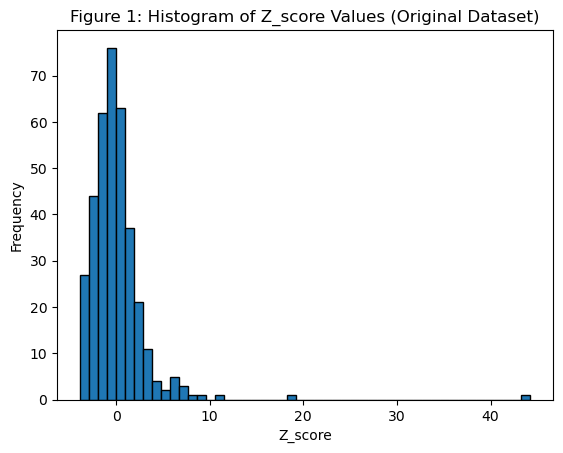

In [37]:
# Plotting the histogram
plt.hist(given_group['z_score'], bins=50, edgecolor='black')
plt.xlabel('Z_score')
plt.ylabel('Frequency')
plt.title('Figure 1: Histogram of Z_score Values (Original Dataset)')
plt.show()

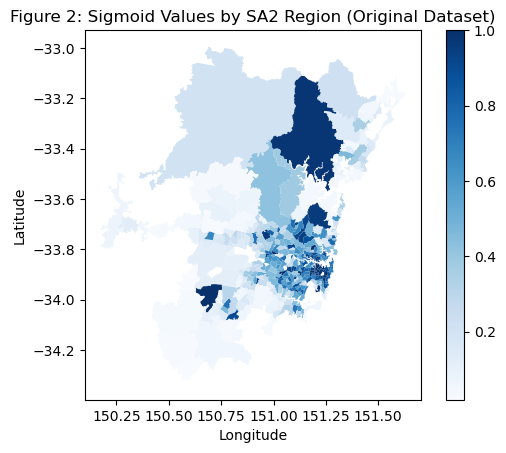

In [38]:
sql = """
SELECT geom, 
      sigmoid 
FROM given_group
"""
visual = gpd.read_postgis(sql, conn, geom_col = 'geom')
visual.plot(column='sigmoid', cmap='Blues', legend=True)

# Add title and axis labels
plt.title("Figure 2: Sigmoid Values by SA2 Region (Original Dataset)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

In [39]:
sql = """
SELECT sa2_name21, sigmoid
FROM given_group
GROUP BY sa2_name21, sigmoid
ORDER BY sigmoid DESC
"""
query(conn, sql)

,sa2_name21,sigmoid
0,Sydney (North) - Millers Point,1.000000
1,Sydney (South) - Haymarket,1.000000
2,Darlinghurst,0.999974
3,Banksmeadow,0.999876
4,Parramatta - North,0.999793
...,...,...
355,Cranebrook - Castlereagh,0.025751
356,Blue Haven - San Remo,0.024833
357,Lake Munmorah - Mannering Park,0.023958
358,Bargo,0.021199


### Data Analysis after Additional Datasets

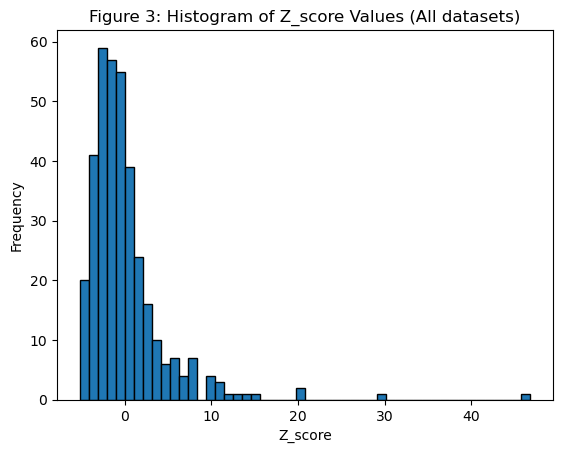

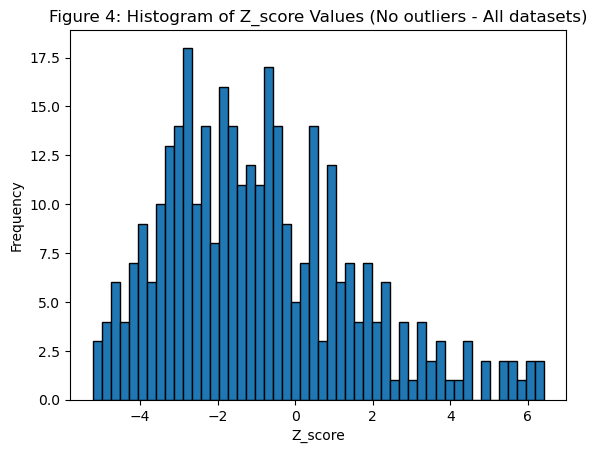

In [40]:
# Plotting the histogram
plt.hist(sydney['z_score'], bins=50, edgecolor='black')
plt.xlabel('Z_score')
plt.ylabel('Frequency')
plt.title('Figure 3: Histogram of Z_score Values (All datasets)')
plt.show()

Q1 = np.percentile(sydney['z_score'], 25)
Q3 = np.percentile(sydney['z_score'], 75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
no_outlier_grouped= sydney[~((sydney['z_score'] < lower_bound) | (sydney['z_score'] > upper_bound))]

# Plotting the histogram
plt.hist(no_outlier_grouped['z_score'], bins=50, edgecolor='black')
plt.xlabel('Z_score')
plt.ylabel('Frequency')
plt.title('Figure 4: Histogram of Z_score Values (No outliers - All datasets)')
plt.show()

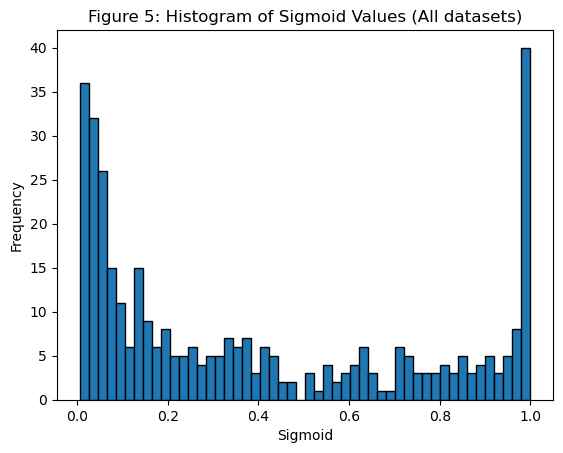

In [41]:
plt.hist(sydney['sigmoid'], bins=50, edgecolor='black')
plt.xlabel('Sigmoid')
plt.ylabel('Frequency')
plt.title('Figure 5: Histogram of Sigmoid Values (All datasets)')
plt.show()

In [42]:
sql = """
SELECT * FROM sydney
ORDER BY sigmoid DESC
"""
query(conn, sql)

,sa2_name21,geom,z_score,sigmoid
0,Sydney (North) - Millers Point,0106000020E6100000030000000103000000010000000E...,46.844083,1.000000
1,Sydney (South) - Haymarket,0106000020E610000001000000010300000001000000B1...,29.689276,1.000000
2,Chippendale,0106000020E6100000010000000103000000010000007E...,20.116452,1.000000
3,Darlinghurst,0106000020E610000001000000010300000001000000A8...,19.959207,1.000000
4,Surry Hills,0106000020E610000001000000010300000001000000A2...,15.026439,1.000000
...,...,...,...,...
355,Picton - Tahmoor - Buxton,0106000020E6100000010000000103000000010000001C...,-4.911484,0.007308
356,Cranebrook - Castlereagh,0106000020E6100000010000000103000000010000003A...,-4.954931,0.006999
357,Lake Munmorah - Mannering Park,0106000020E6100000010000000103000000010000009B...,-5.011565,0.006616
358,Bargo,0106000020E61000000100000001030000000100000055...,-5.123215,0.005922


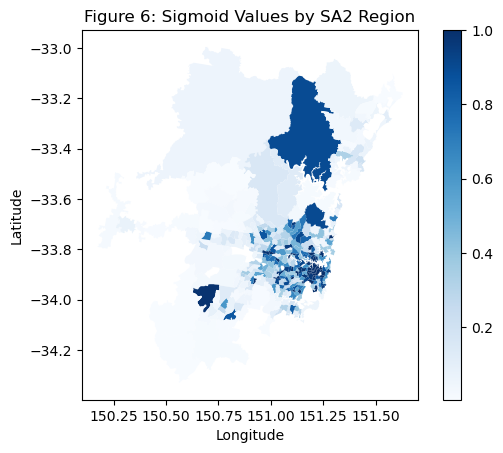

In [43]:
sql = """
SELECT geom, 
      sigmoid 
FROM sydney
"""
visual = gpd.read_postgis(sql, conn, geom_col = 'geom')
visual.plot(column='sigmoid', cmap='Blues', legend=True)

# Add title and axis labels
plt.title("Figure 6: Sigmoid Values by SA2 Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

In [44]:
sql = """
SELECT sa2.sa2_name21, 
       income.median_income, 
       sydney.sigmoid
FROM sa2
JOIN sydney ON (sa2.sa2_name21 = sydney.sa2_name21)
JOIN income ON (sa2.sa2_name21 = income.sa2_name)
GROUP BY sa2.sa2_name21, income.median_income, sydney.sigmoid
ORDER BY sigmoid DESC
LIMIT 20
"""
query(conn, sql)

,sa2_name21,median_income,sigmoid
0,Darlinghurst,71676,1.000000
1,Surry Hills,67312,1.000000
2,Bondi Junction - Waverly,64030,0.999975
3,North Sydney - Lavender Bay,82003,0.999957
4,Potts Point - Woolloomooloo,73659,0.999673
5,Banksmeadow,68584,0.999632
6,Glebe - Forest Lodge,67002,0.999564
7,Randwick - North,72651,0.998940
8,Paddington - Moore Park,80692,0.996724
9,St Leonards - Naremburn,83498,0.995804


In [45]:
sql = """
SELECT income.median_income, sydney.sigmoid
FROM sydney 
JOIN income ON (sydney.sa2_name21 = income.sa2_name)
WHERE income.median_income IS NOT NULL AND sydney.sigmoid IS NOT NULL
GROUP BY income.median_income, sydney.sigmoid
ORDER BY sigmoid DESC, median_income DESC;
"""
sigmoid_and_income = query(conn, sql)
sigmoid_and_income.corr()

,median_income,sigmoid
median_income,1.000000,0.292718
sigmoid,0.292718,1.000000


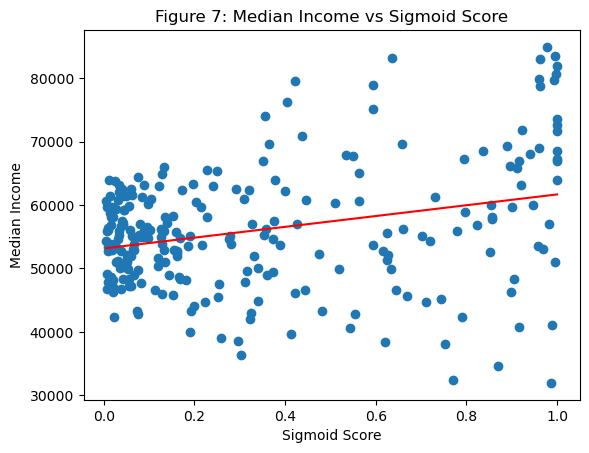

In [46]:
#Line of best fit
coefficients = np.polyfit(sigmoid_and_income['sigmoid'], sigmoid_and_income['median_income'], 1)
line = np.poly1d(coefficients)
plt.plot(sigmoid_and_income['sigmoid'], line(sigmoid_and_income['sigmoid']), color='red')

# Plotting the scatter plot
plt.scatter(sigmoid_and_income['sigmoid'],sigmoid_and_income['median_income'])
plt.ylabel('Median Income')
plt.xlabel('Sigmoid Score')
plt.title('Figure 7: Median Income vs Sigmoid Score')
plt.show()

In [47]:
conn.close()